In [35]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import geopandas as gpd

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [46]:
file = cnst.GRIDSAT_PERU + 'daily/gridsat_WA_-40Min_5000km2_13-19UTCperDay_2003*.nc'

In [22]:
import salem

In [38]:
def draw_map(ax, t, lat, lon, **kwargs):
    
    fname = '/home/ck/DIR/cornkle/data/HUARAZ/shapes/riosan_sel_one.shp'
    
#     sdf = salem.read_shapefile(fname)
#     
    
    sdf = gpd.read_file(fname)
    sdf = salem.transform_geopandas(sdf, to_crs=salem.wgs84)
    
    plt.contourf(lon, lat, t, transform=ccrs.PlateCarree(), **kwargs)
    ax.coastlines()
    ax.add_geometries(sdf.geometry, crs=ccrs.PlateCarree())
    #ipdb.set_trace()
    
#     ax.add_geometries(Reader(fname).geometries(),
#                   ccrs.PlateCarree(),
#                   facecolor='white', hatch='xxxx')
    # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.xlabels_top = False
    xl.ylabels_right = False
    # Countries
    #ax.add_feature(cartopy.feature.BORDERS, linestyle='--');
    plt.colorbar()


In [41]:
gpd.read_file(fname).crs

{'init': 'epsg:32718'}

In [47]:
dat = xr.open_mfdataset(file, combine='nested', concat_dim='time')

In [28]:
# sample the colormaps that you want to use. Use 128 from each so we get 256
# colors in total
colors1 = plt.cm.terrain(np.linspace(0., 1, 150))
colors2 = plt.cm.Reds(np.linspace(0, 1, 100))

# combine them and build a new colormap
colors = np.vstack((colors2, colors1))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [29]:
print(19,22,1,4,7,10,13,16, 'LT')
print(0,3,6,9,12,15,18,21, 'UTC')

19 22 1 4 7 10 13 16 LT
0 3 6 9 12 15 18 21 UTC


In [30]:
box = [-79,-65,-17,-3] #[-79,-74,-12,-7]  #, lon=slice(-79,-74), lat=slice(-12,-7))
topo = xr.open_dataarray(cnst.TOPO_1MIN)
topo =  topo.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

In [44]:
era5 = xr.open_mfdataset(cnst.ERA5_HOURLY_PL_HU+'/*2003_0*.nc') #xr.open_dataset(pl)
era5 = uda.flip_lat(era5)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


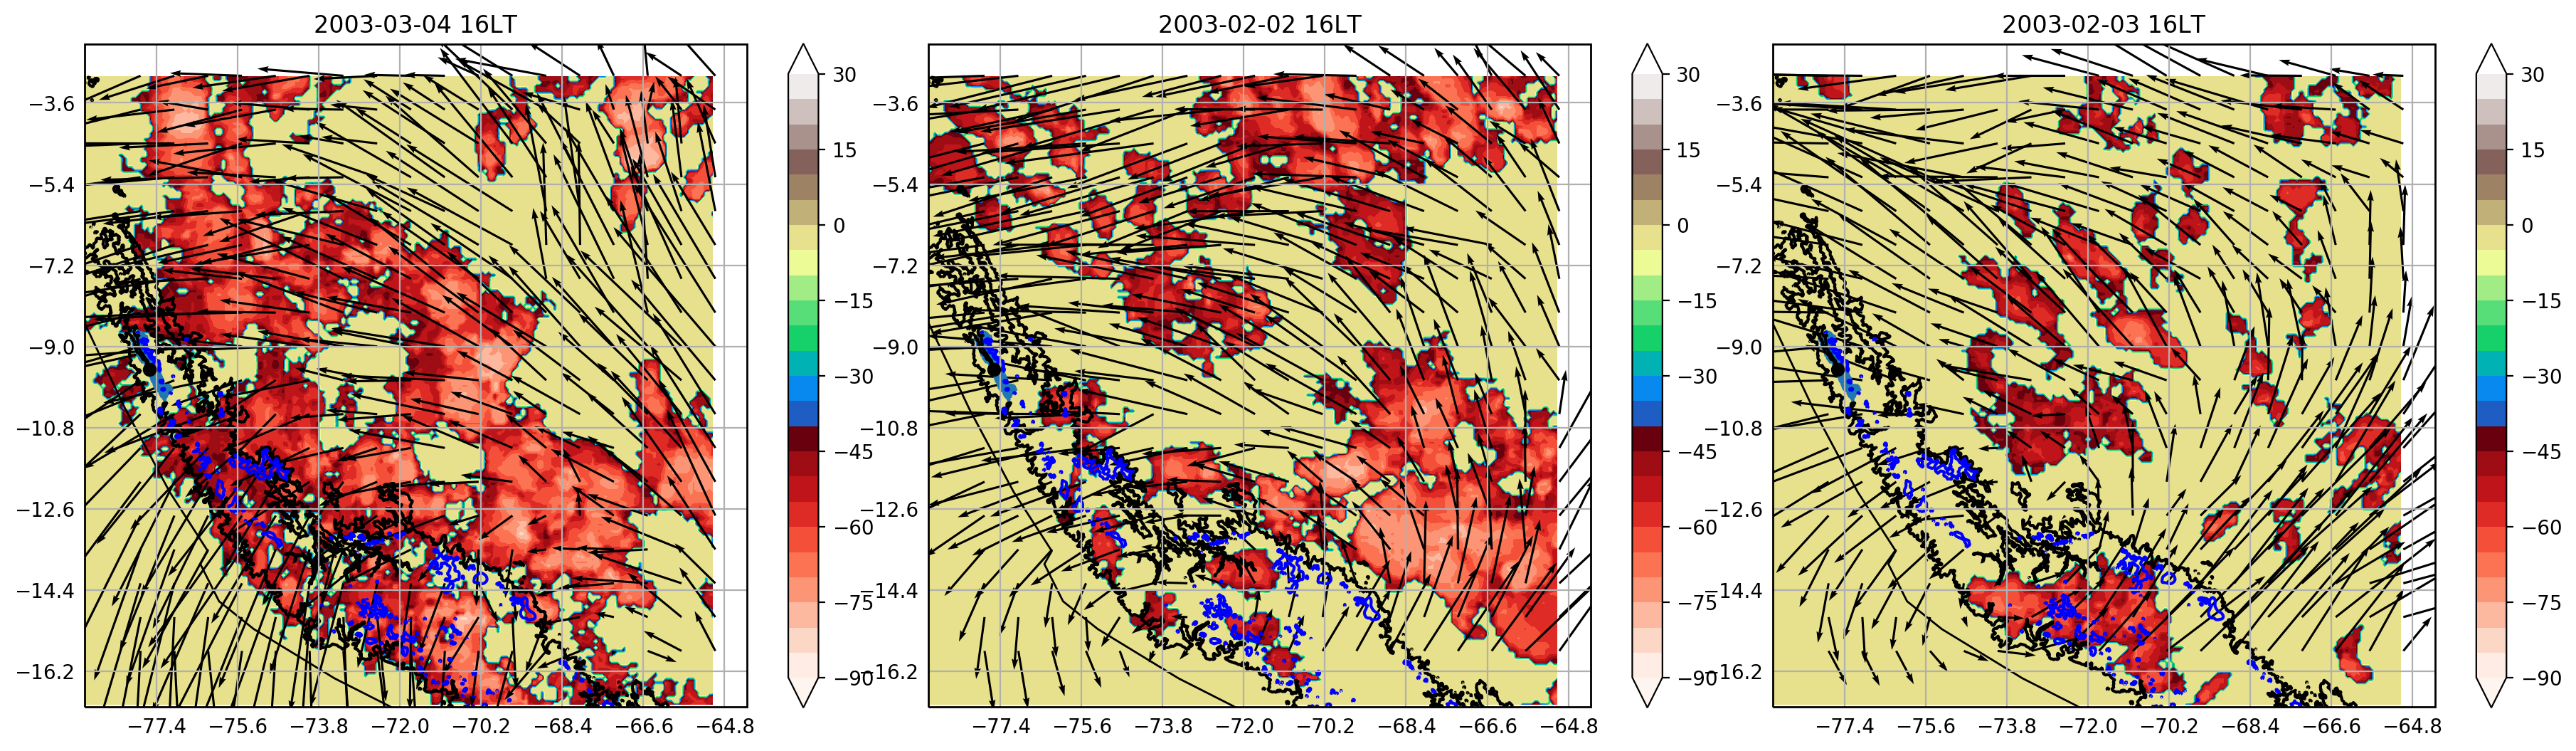

In [50]:
h = 21
dates = ['2003-03-04', '2003-02-02', '2003-02-03']

f=plt.figure(figsize=(18,5), dpi=200)

for inds, date in enumerate(dates):
    
    cloud = dat.sel(time=date, lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).load().squeeze()
    era =era5.sel(time=date, longitude=slice(box[0],box[1]), latitude=slice(box[2],box[3])).load().squeeze()

    ax = f.add_subplot(1,3,inds+1, projection=ccrs.PlateCarree())
    
    draw_map(ax,cloud['tir']/100, cloud.lat, cloud.lon, cmap=mymap, extend='both', levels=np.arange(-90,31,5))
    plt.plot(-77.55,-9.51, 'ko')
    ax.contour(topo.lon, topo.lat,topo.values, levels=[3000,4900], colors=['black', 'blue'])
    plt.title(date+' '+str(h-5)+'LT')

    st=3
    sarrow = 5
    xquiv = era.longitude[sarrow::st]
    yquiv = era.latitude[sarrow::st]

    uu = (era['u'].sel(level=200, time=(era['time.hour']==h)).squeeze())[sarrow::st, sarrow::st]
    vv = (era['v'].sel(level=200, time=(era['time.hour']==h)).squeeze())[sarrow::st, sarrow::st]

    qu = ax.quiver(xquiv, yquiv,uu , vv, scale=60)

plt.tight_layout()